In [13]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
def resize_image (img, new_width=256, new_height=256):
    height, width = img.shape[:2]
    
    scale_x = width / new_width
    scale_y = height / new_height
    resized_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    
    for i in range(new_height):
        for j in range(new_width):
            orig_x = int(j * scale_x)
            orig_y = int(i * scale_y)
            resized_img[i, j] = img[orig_y, orig_x]  
    return resized_img

In [15]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [16]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


100%|██████████| 100/100 [00:02<00:00, 45.89it/s]


Rosacea


100%|██████████| 100/100 [00:02<00:00, 43.95it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


In [17]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [18]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [19]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [20]:
def skin_mask(img):
    if len(img.shape) == 2: 
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    ycrcb = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            y, cr, cb = ycrcb[i, j]
            if 133 <= cr <= 173 and 77 <= cb <= 127:
                mask[i, j] = 255
    return mask


In [21]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [22]:
def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

In [23]:
def operasi_prewitt(citra):
    gx = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])
    gy = np.array([[1, 1, 1],
                   [0, 0, 0],
                   [-1, -1, -1]])
    padded = np.pad(citra, 1, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+3, j:j+3]
            px = np.sum(region * gx)
            py = np.sum(region * gy)
            result[i, j] = min(255, abs(px) + abs(py))
    return result


In [24]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    blurred = median_filtering(gray_img)
    citra_prewitt = operasi_prewitt(blurred)
    mask = skin_mask(citra_prewitt)
    masked = cv.bitwise_and(citra_prewitt, citra_prewitt, mask=mask)
    citra_opening = opening(citra_prewitt)
    normalizeData = normalize(citra_opening)  

    dataPreprocessed.append(normalizeData)


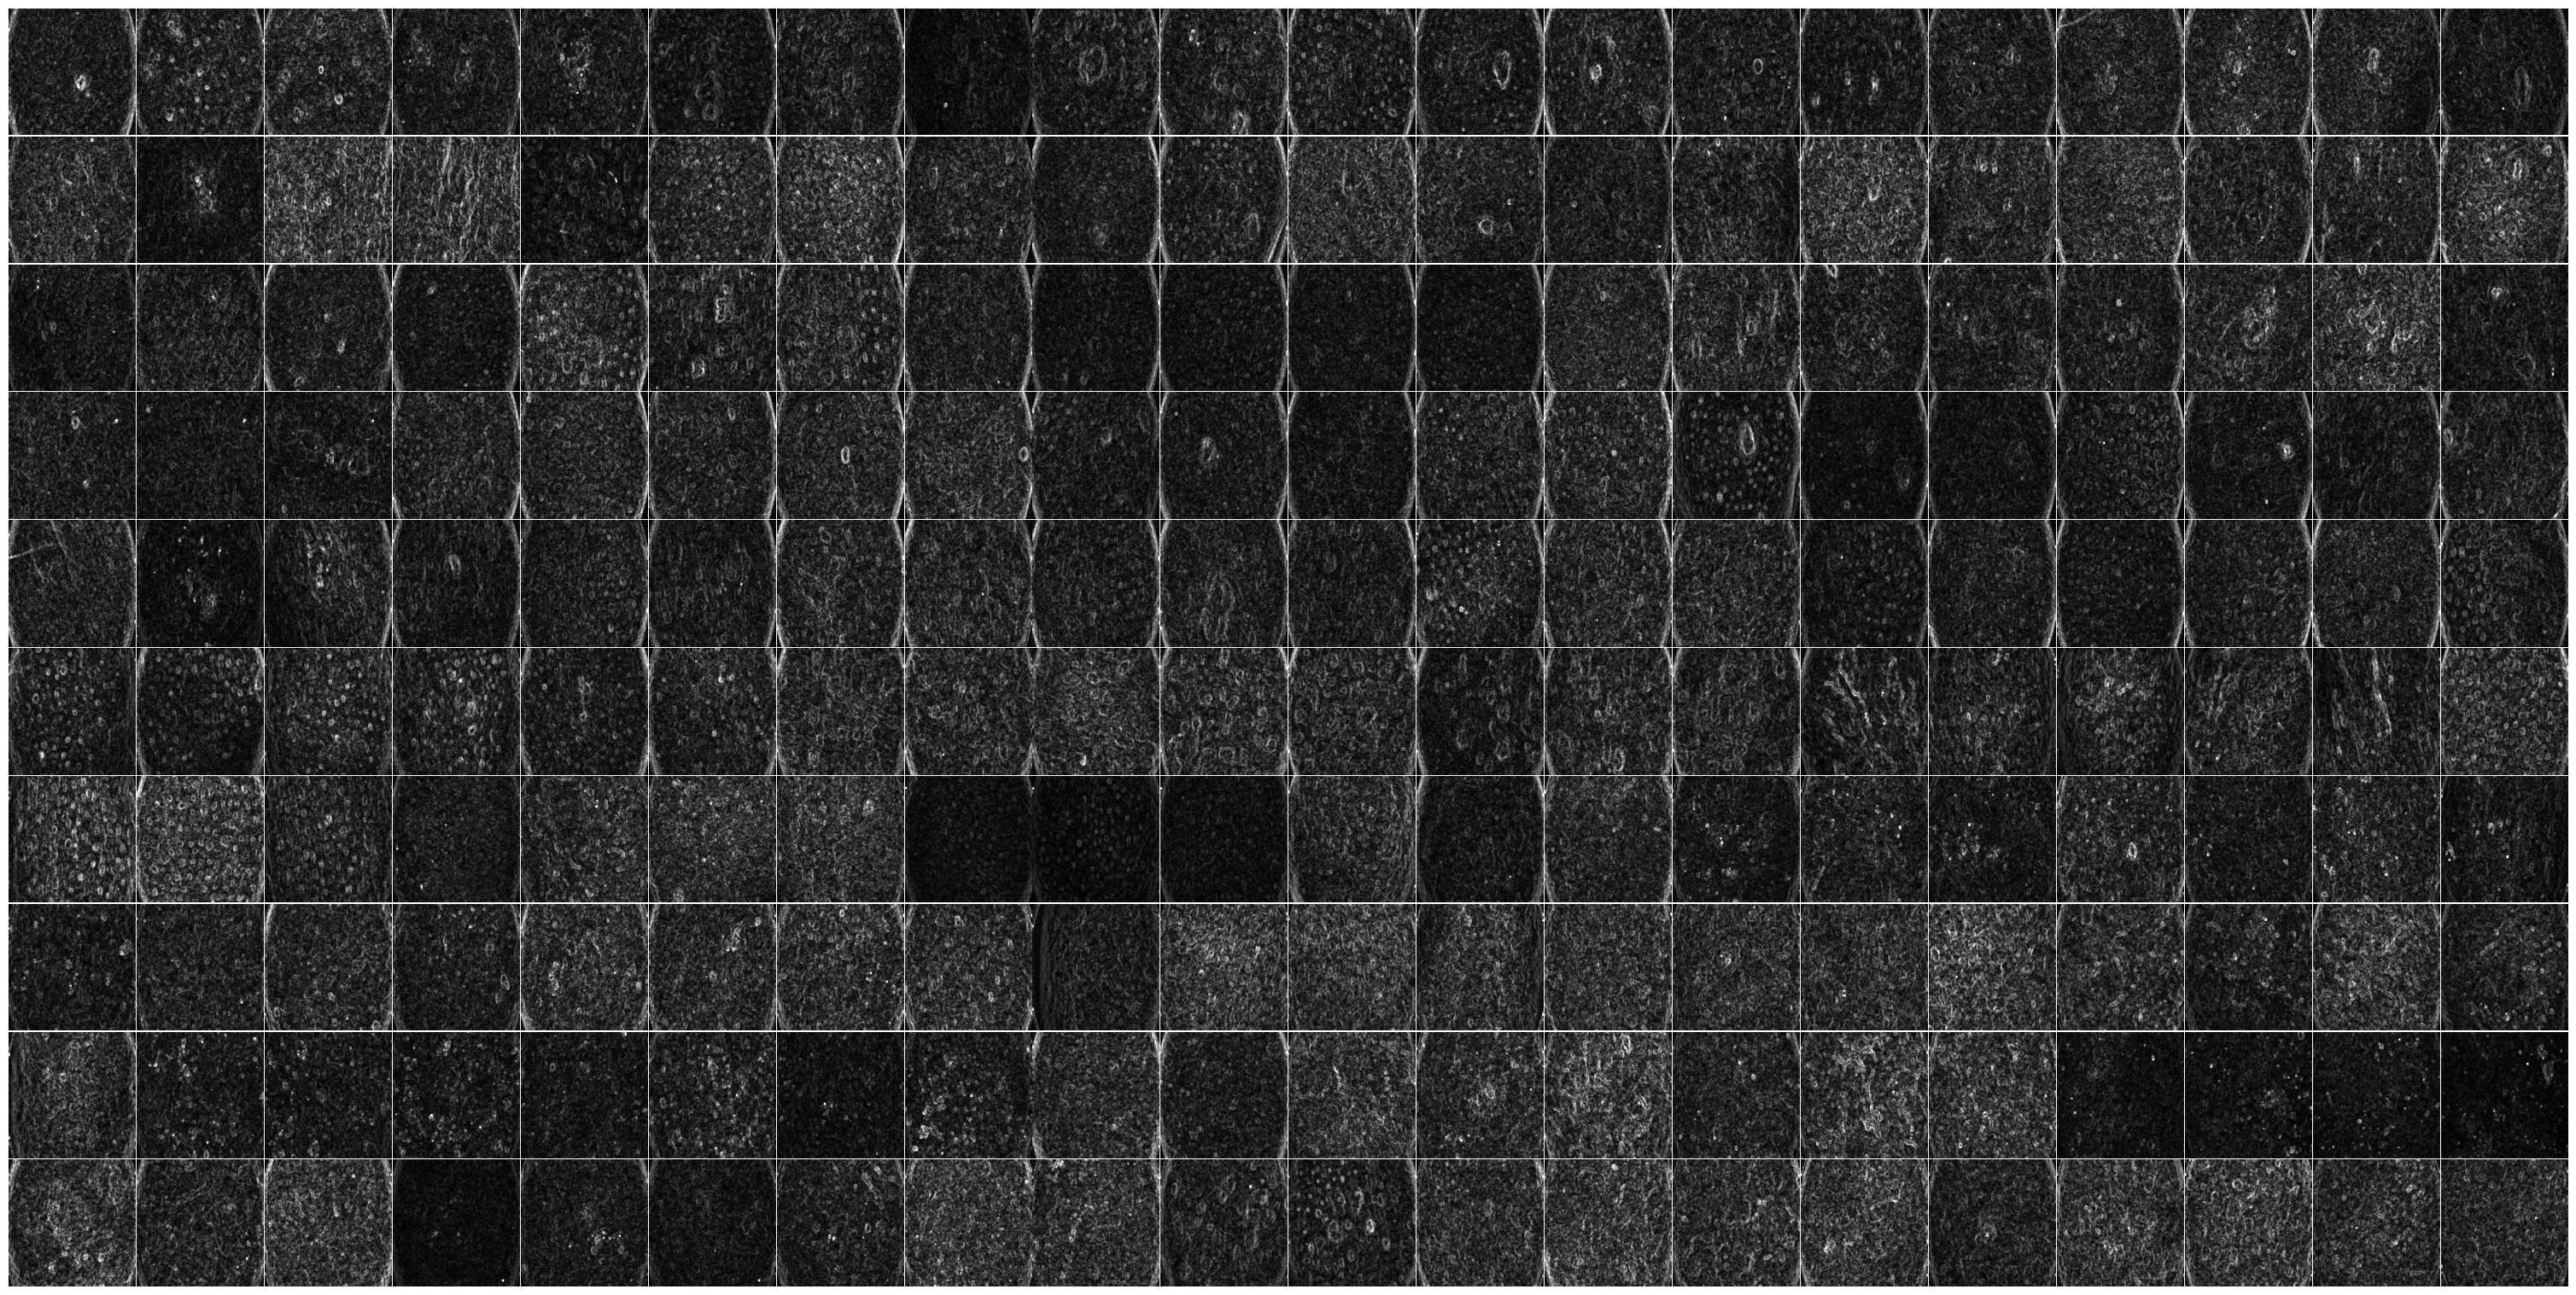

In [25]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

In [26]:
for i in range(len(dataPreprocessed)):  
    dataPreprocessed[i] = (dataPreprocessed[i] / np.max(dataPreprocessed[i]) * 255).astype(np.uint8)  # Normalisasi ke uint8

<h1>Feature Extraction</h1>

In [27]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [28]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [29]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [30]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [31]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [32]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [33]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [34]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [35]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [36]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [37]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [38]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [39]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [40]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [41]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [42]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [43]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [56]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


In [45]:
print(df.describe())  # Lihat ringkasan statistik fitur

NameError: name 'df' is not defined

<h1>CSV</h1>

In [58]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_7.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_7.csv')
hasilEkstrak

Filename          Label   Contrast0  Contrast45  Contrast90  \
0    101_5.jpg  Acne Vulgaris  214.984773  305.150311  144.759850   
1    102_2.jpg  Acne Vulgaris  246.945527  341.142299  187.871109   
2    103_2.jpg  Acne Vulgaris  289.356449  414.947943  214.713434   
3    106_1.jpg  Acne Vulgaris  170.424525  233.409612  112.405070   
4    106_7.jpg  Acne Vulgaris  191.251042  266.288366  119.725934   
..         ...            ...         ...         ...         ...   
195  118_2.jpg        Rosacea  197.767034  277.816301  142.548407   
196  118_3.jpg        Rosacea  440.507843  595.405844  297.838802   
197  118_4.jpg        Rosacea  526.332583  751.255040  362.184084   
198  119_1.jpg        Rosacea  304.465411  468.716924  249.140441   
199  119_2.jpg        Rosacea  270.515456  392.737747  202.387331   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     285.423883      0.551512       0.367983       0.561356        0.368755   
1     373.650873      0.503282       0.308073       0.512901        0.309409   
2     417.302899      0.536096       0.343760       0.539689        0.343304   
3     236.430973      0.524311       0.332319       0.530801        0.330844   
4     255.254810      0.511145       0.314536       0.519231        0.318276   
..           ...           ...            ...            ...             ...   
195   282.655917      0.519362       0.326756       0.523870        0.324630   
196   618.430911      0.497620       0.294881       0.497592        0.294060   
197   706.107343      0.512315       0.317621       0.519399        0.318173   
198   430.076524      0.507746       0.303096       0.502454        0.303048   
199   383.931503      0.519751       0.318093       0.515770        0.318205   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.035692  0.020605  0.186114  0.143016  0.188922   0.143543   
1    ...  0.015369  0.007271  0.121106  0.085380  0.123974   0.085273   
2    ...  0.026541  0.014251  0.161221  0.119479  0.162914   0.119378   
3    ...  0.020886  0.010542  0.141882  0.102936  0.144518   0.102672   
4    ...  0.017557  0.008496  0.129461  0.091505  0.132504   0.092173   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.021085  0.010635  0.143366  0.103788  0.145206   0.103127   
196  ...  0.014583  0.006737  0.120107  0.082302  0.120761   0.082078   
197  ...  0.021125  0.010662  0.142423  0.102860  0.145344   0.103256   
198  ...  0.016116  0.007771  0.127601  0.087811  0.126948   0.088152   
199  ...  0.018738  0.009203  0.137357  0.095837  0.136887   0.095935   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.870507       0.815892       0.913656        0.827794  
1        0.840336       0.779611       0.879261        0.758611  
2        0.818646       0.739653       0.865982        0.738173  
3        0.820567       0.754200       0.883790        0.751021  
4        0.803740       0.726790       0.877456        0.738108  
..            ...            ...            ...             ...  
195      0.796403       0.713619       0.853900        0.708629  
196      0.774664       0.695415       0.848045        0.683630  
197      0.779497       0.684593       0.848311        0.703548  
198      0.787027       0.671730       0.825716        0.698792  
199      0.749751       0.636431       0.813329        0.644570  

[200 rows x 30 columns]

<Axes: >

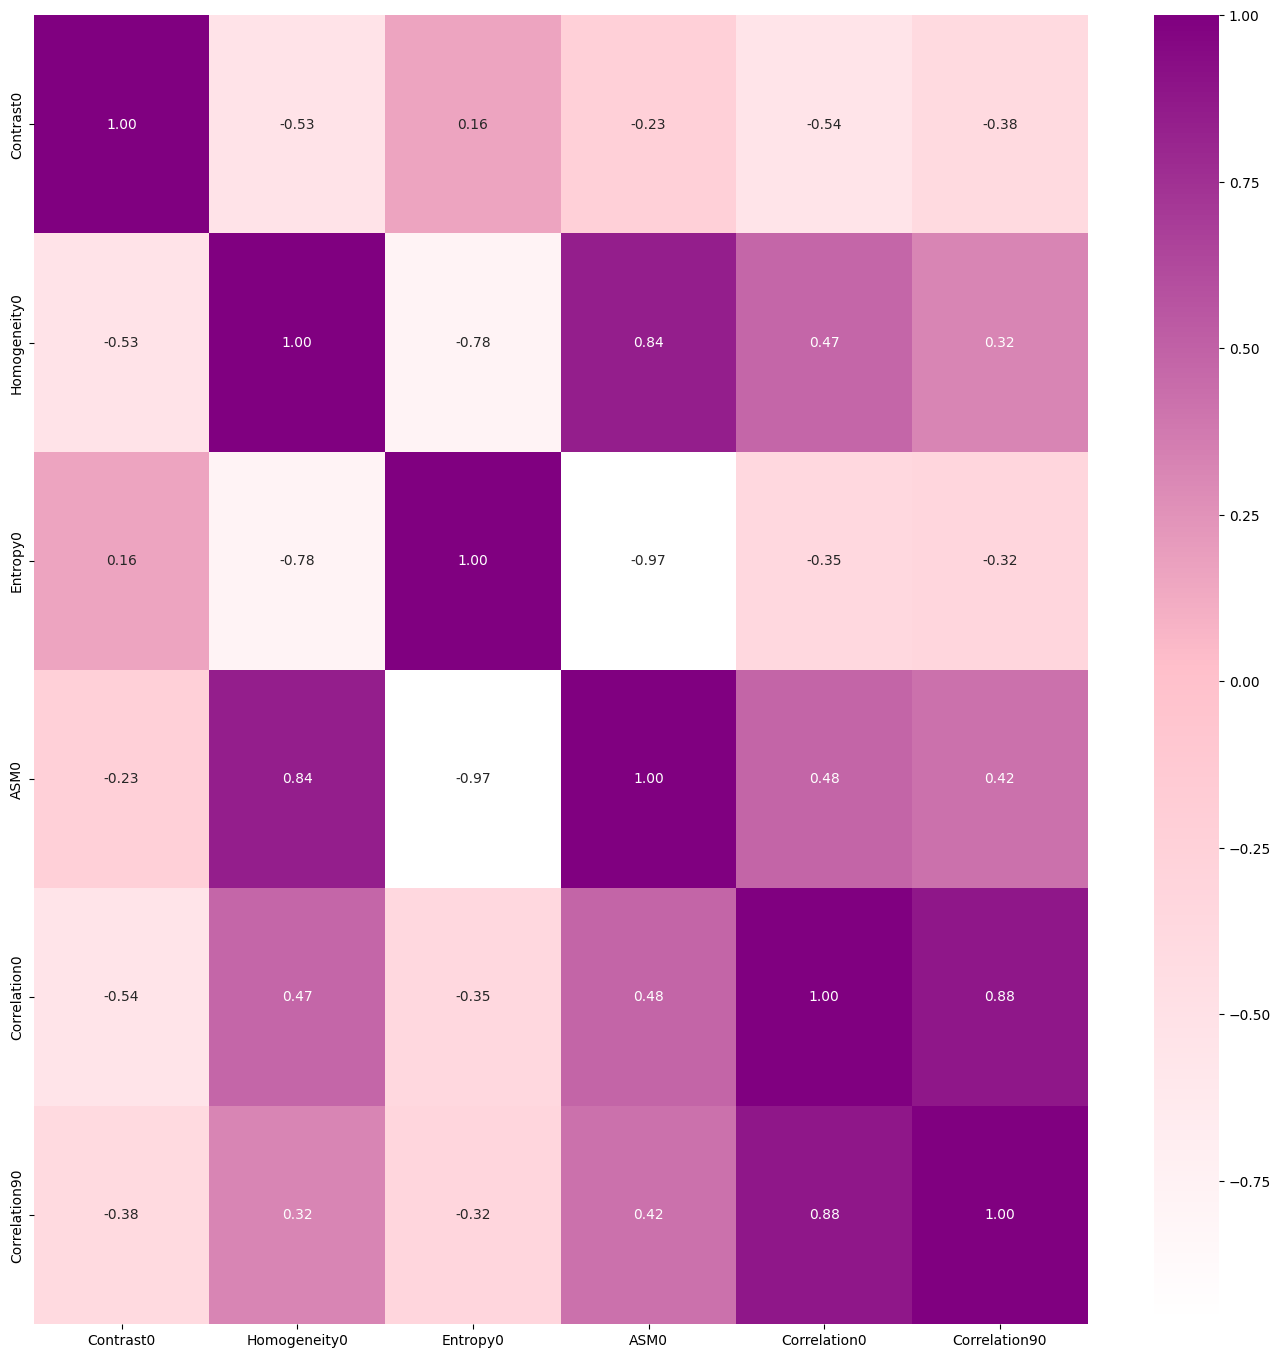

In [47]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [48]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 6)
(60, 6)


In [49]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=7, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=10)

In [51]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.99      0.97      0.98        69
      Rosacea       0.97      0.99      0.98        71

     accuracy                           0.98       140
    macro avg       0.98      0.98      0.98       140
 weighted avg       0.98      0.98      0.98       140

[[67  2]
 [ 1 70]]
Accuracy: 0.9785714285714285

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.76      0.84      0.80        31
      Rosacea       0.81      0.72      0.76        29

     accuracy                           0.78        60
    macro avg       0.79      0.78      0.78        60
 weighted avg       0.79      0.78      0.78        60

[[26  5]
 [ 8 21]]
Accuracy: 0.7833333333333333


In [52]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.79      0.72      0.76        69
      Rosacea       0.75      0.82      0.78        71

     accuracy                           0.77       140
    macro avg       0.77      0.77      0.77       140
 weighted avg       0.77      0.77      0.77       140

[[50 19]
 [13 58]]
Accuracy: 0.7714285714285715

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.85      0.90      0.88        31
      Rosacea       0.89      0.83      0.86        29

     accuracy                           0.87        60
    macro avg       0.87      0.87      0.87        60
 weighted avg       0.87      0.87      0.87        60

[[28  3]
 [ 5 24]]
Accuracy: 0.8666666666666667


In [53]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.78      0.87      0.82        69
      Rosacea       0.86      0.76      0.81        71

     accuracy                           0.81       140
    macro avg       0.82      0.82      0.81       140
 weighted avg       0.82      0.81      0.81       140

[[60  9]
 [17 54]]
Accuracy: 0.8142857142857143

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.71      0.87      0.78        31
      Rosacea       0.82      0.62      0.71        29

     accuracy                           0.75        60
    macro avg       0.76      0.75      0.74        60
 weighted avg       0.76      0.75      0.75        60

[[27  4]
 [11 18]]
Accuracy: 0.75


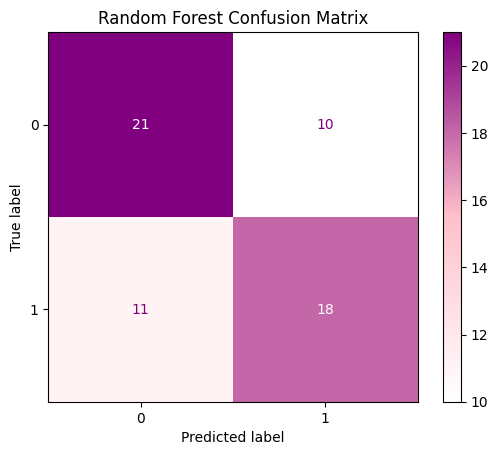

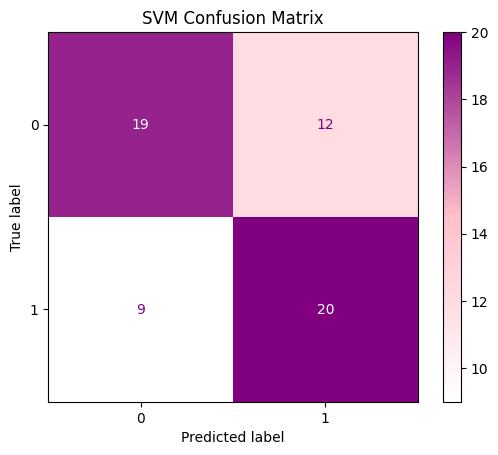

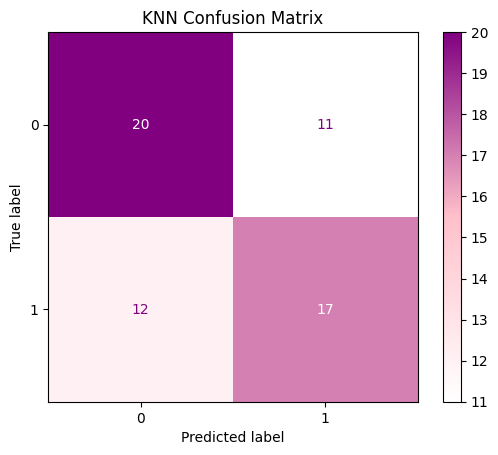

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")